# Enhanced 1D CNN for 19-Class Multi-Label ECG Classification (v03)

**Key Features:**
- 19-class multi-label classification (18 cardiac diseases + Healthy)
- **Full-length variable recordings** (5-120 seconds, no windowing)
- Enhanced architecture: Squeeze-Excitation blocks + Temporal Attention
- Focal loss for class imbalance
- **Outputs show disease names only** (not ICD codes)

**Architecture:** 64→128→256→512 filters + SE + Attention + Adaptive Pooling

## 1. Setup & Dependencies

In [1]:
# Install dependencies
!pip install wfdb neurokit2 h5py tensorflow scikit-learn matplotlib seaborn pandas numpy scipy -q

print("✓ Dependencies installed")

✓ Dependencies installed


In [2]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import h5py
import wfdb
from scipy.signal import butter, filtfilt, resample
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, hamming_loss, confusion_matrix, classification_report
)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print("✓ Imports complete")

TensorFlow version: 2.20.0
Num GPUs Available: 0
✓ Imports complete


## 1.1 HuggingFace Setup (Optional)

In [3]:
# HuggingFace Setup (optional - set ENABLE_HF_UPLOAD=True to enable)
# Install huggingface_hub if not already installed
try:
    from huggingface_hub import HfApi, login, create_repo
except ImportError:
    print("Installing huggingface_hub...")
    import subprocess
    subprocess.run(['.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'huggingface-hub', '-q'], check=True)
    from huggingface_hub import HfApi, login, create_repo

# Set this to True to enable HuggingFace uploads
ENABLE_HF_UPLOAD = True  # Change to True to enable uploads

if ENABLE_HF_UPLOAD:
    from getpass import getpass
    import os
    
    print("HuggingFace Setup")
    print("=" * 60)
    print("Please provide your Hugging Face token with WRITE access:")
    print("Get it from: https://huggingface.co/settings/tokens")
    print()
    
    # Try to get token from environment variable first
    HF_TOKEN = os.environ.get('HF_TOKEN')
    
    if not HF_TOKEN:
        HF_TOKEN = getpass("Enter your HF token (hidden): ")
    
    # Login
    try:
        login(token=HF_TOKEN, add_to_git_credential=True)
        print("✓ Logged in to Hugging Face")
    except Exception as e:
        print(f"❌ Login failed: {e}")
        print("HuggingFace uploads will be disabled")
        ENABLE_HF_UPLOAD = False
    
    if ENABLE_HF_UPLOAD:
        # Repository names
        MODEL_REPO = "Neural-Network-Project/ECG-Disease-Classifier"
        DATASET_REPO = "Neural-Network-Project/ECG-database"
        
        # Initialize API
        api = HfApi()
        
        # Ensure repos exist
        try:
            api.repo_info(repo_id=MODEL_REPO, repo_type="model")
            print(f"✓ Model repo exists: {MODEL_REPO}")
        except:
            try:
                create_repo(repo_id=MODEL_REPO, repo_type="model", private=False)
                print(f"✓ Created model repo: {MODEL_REPO}")
            except Exception as e:
                print(f"⚠️  Could not create model repo: {e}")
        
        try:
            api.repo_info(repo_id=DATASET_REPO, repo_type="dataset")
            print(f"✓ Dataset repo exists: {DATASET_REPO}")
        except:
            try:
                create_repo(repo_id=DATASET_REPO, repo_type="dataset", private=False)
                print(f"✓ Created dataset repo: {DATASET_REPO}")
            except Exception as e:
                print(f"⚠️  Could not create dataset repo: {e}")
        
        print("=" * 60)
else:
    print("HuggingFace uploads disabled (set ENABLE_HF_UPLOAD=True to enable)")
    MODEL_REPO = None
    DATASET_REPO = None
    api = None

c:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFace Setup
Please provide your Hugging Face token with WRITE access:
Get it from: https://huggingface.co/settings/tokens



Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ Logged in to Hugging Face
✓ Model repo exists: Neural-Network-Project/ECG-Disease-Classifier
✓ Dataset repo exists: Neural-Network-Project/ECG-database


In [4]:
# Configuration
NOTEBOOK_VERSION = "v03"
DATA_DIR = "../.data/"
ECG_DIR = os.path.join(DATA_DIR, "data/Child_ecg/")
CSV_PATH = os.path.join(DATA_DIR, "data/AttributesDictionary.csv")
OUTPUT_DIR = os.path.join(DATA_DIR, "artifacts/multilabel_v3_full_length/")
HDF5_FILE = os.path.join(OUTPUT_DIR, "ecg_full_length_19classes.h5")
MODEL_NAME = "Enhanced_1D_CNN_19Classes_v3"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training parameters
BATCH_SIZE = 16  # Smaller for variable lengths
EPOCHS = 100
LEARNING_RATE = 1e-3
TARGET_FS = 500  # Target sampling frequency
TARGET_CHANNELS = 12
CHECKPOINT_EVERY = 10  # Save checkpoint to HuggingFace every N epochs

print(f"Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Checkpoint every: {CHECKPOINT_EVERY} epochs (HuggingFace)")

Configuration:
  Data directory: ../.data/
  Output directory: ../.data/artifacts/multilabel_v3_full_length/
  Batch size: 16
  Epochs: 100
  Checkpoint every: 10 epochs (HuggingFace)


## 1.5 Extract Split Archive (if needed)

In [5]:
# Extract split archives if needed (local environment)
import os
import zipfile

# Check if Child_ecg directory exists and has files
def count_files_recursive(directory):
    """Count all files recursively in a directory"""
    if not os.path.exists(directory):
        return 0
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

ecg_file_count = count_files_recursive(ECG_DIR)

print(f"Checking ECG data extraction...")
print(f"  ECG directory: {ECG_DIR}")
print(f"  Files found: {ecg_file_count}")

# If directory doesn't exist or has very few files, extract the archives
if ecg_file_count < 1000:  # Expect tens of thousands of files
    print(f"\n⚠️  Insufficient ECG files detected. Checking for archives to extract...")
    
    # Look for split archive files
    archive_dir = os.path.join(DATA_DIR, "data")
    zip_file = os.path.join(archive_dir, "Child_ecg.zip")
    z01_file = os.path.join(archive_dir, "Child_ecg.z01")
    
    if os.path.exists(zip_file):
        print(f"\n✓ Found archive files:")
        print(f"  - {zip_file}")
        if os.path.exists(z01_file):
            print(f"  - {z01_file}")
        
        print(f"\nExtracting archives...")
        print(f"This may take several minutes...")
        
        try:
            # For split archives (.z01 + .zip), we need to use 7zip or similar
            if os.path.exists(z01_file):
                # Try using 7zip if available
                try:
                    import subprocess
                    # Try 7z command on Windows (usually installed with 7-Zip)
                    result = subprocess.run(
                        ['7z', 'x', zip_file, f'-o{archive_dir}', '-y'],
                        capture_output=True,
                        text=True
                    )
                    if result.returncode == 0:
                        print(f"✓ Successfully extracted using 7zip")
                    else:
                        raise Exception("7zip extraction failed")
                except:
                    # Fallback: Try PowerShell Expand-Archive (may not work with split archives)
                    print("7zip not available, trying PowerShell...")
                    result = subprocess.run(
                        ['powershell', '-Command', 
                         f'Expand-Archive -Path "{zip_file}" -DestinationPath "{archive_dir}" -Force'],
                        capture_output=True,
                        text=True
                    )
                    if result.returncode == 0:
                        print(f"✓ Extraction attempted with PowerShell")
                    else:
                        print(f"PowerShell extraction failed, trying Python zipfile...")
                        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                            zip_ref.extractall(archive_dir)
                        print(f"✓ Extraction attempted with zipfile")
            else:
                # Single zip file, use Python's zipfile
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(archive_dir)
                print(f"✓ Successfully extracted zip file")
            
            # Verify extraction
            new_file_count = count_files_recursive(ECG_DIR)
            print(f"\n✓ Extraction complete!")
            print(f"  Files extracted: {new_file_count}")
            
            if new_file_count < 1000:
                print(f"\n⚠️  Warning: Expected more files. Archive may not have extracted completely.")
                print(f"  Please manually extract {zip_file} using 7-Zip if needed.")
        
        except Exception as e:
            print(f"\n❌ Error during extraction: {e}")
            print(f"\nPlease manually extract the following file:")
            print(f"  {zip_file}")
            print(f"To directory: {archive_dir}")
            print(f"\nYou can use 7-Zip (https://www.7-zip.org/) to extract split archives.")
            raise
    else:
        print(f"\n❌ Archive files not found!")
        print(f"  Expected: {zip_file}")
        print(f"\nPlease ensure the archive files are present in {archive_dir}")
        raise FileNotFoundError(f"Archive not found: {zip_file}")
else:
    print(f"✓ ECG data already extracted ({ecg_file_count} files found)")

Checking ECG data extraction...
  ECG directory: ../.data/data/Child_ecg/
  Files found: 56761
✓ ECG data already extracted (56761 files found)


## 2. Disease Mapping & Class Definitions

In [6]:
# ICD codes to Disease Names mapping
ICD_TO_DISEASE_NAME = {
    'I40.0': 'Fulminant/Viral Myocarditis',
    'I40.9': 'Acute Myocarditis',
    'I51.4': 'Myocarditis Unspecified',
    'I42.0': 'Dilated Cardiomyopathy',
    'I42.2': 'Hypertrophic Cardiomyopathy',
    'I42.9': 'Cardiomyopathy Unspecified',
    'Q24.8': 'Noncompaction Ventricular Myocardium',
    'M30.3': 'Kawasaki Disease',
    'Q21.0': 'Ventricular Septal Defect',
    'Q21.1': 'Atrial Septal Defect',
    'Q21.2': 'Atrioventricular Septal Defect',
    'Q21.3': 'Tetralogy of Fallot',
    'Q22.1': 'Pulmonary Valve Stenosis',
    'Q25.0': 'Patent Ductus Arteriosus',
    'Q25.6': 'Pulmonary Artery Stenosis',
    'I37.0': 'Pulmonary Valve Regurgitation',
    'I34.0': 'Mitral Valve Insufficiency',
    'Q24.9': 'Congenital Heart Malformation',
    'Healthy': 'Healthy'  # Changed from "No Disease (Healthy)" to just "Healthy"
}

# Disease names list (for model outputs - NO ICD codes in outputs)
DISEASE_NAMES = list(ICD_TO_DISEASE_NAME.values())
ICD_CODES = list(ICD_TO_DISEASE_NAME.keys())
NUM_CLASSES = len(DISEASE_NAMES)

# Disease grouping for interpretability
DISEASE_GROUPS = {
    'Myocarditis': ['I40.0', 'I40.9', 'I51.4'],
    'Cardiomyopathy': ['I42.0', 'I42.2', 'I42.9', 'Q24.8'],
    'Kawasaki': ['M30.3'],
    'CHD': ['Q21.0', 'Q21.1', 'Q21.2', 'Q21.3', 'Q22.1', 'Q25.0', 'Q25.6', 'I37.0', 'I34.0', 'Q24.9']
}

print(f"Number of classes: {NUM_CLASSES}")
print(f"\nDisease Names (outputs will show these names ONLY):")
for i, name in enumerate(DISEASE_NAMES, 1):
    print(f"  {i:2d}. {name}")

print(f"\nDisease Groups:")
for group, codes in DISEASE_GROUPS.items():
    names = [ICD_TO_DISEASE_NAME[code] for code in codes]
    print(f"  {group}: {len(codes)} diseases")

Number of classes: 19

Disease Names (outputs will show these names ONLY):
   1. Fulminant/Viral Myocarditis
   2. Acute Myocarditis
   3. Myocarditis Unspecified
   4. Dilated Cardiomyopathy
   5. Hypertrophic Cardiomyopathy
   6. Cardiomyopathy Unspecified
   7. Noncompaction Ventricular Myocardium
   8. Kawasaki Disease
   9. Ventricular Septal Defect
  10. Atrial Septal Defect
  11. Atrioventricular Septal Defect
  12. Tetralogy of Fallot
  13. Pulmonary Valve Stenosis
  14. Patent Ductus Arteriosus
  15. Pulmonary Artery Stenosis
  16. Pulmonary Valve Regurgitation
  17. Mitral Valve Insufficiency
  18. Congenital Heart Malformation
  19. Healthy

Disease Groups:
  Myocarditis: 3 diseases
  Cardiomyopathy: 4 diseases
  Kawasaki: 1 diseases
  CHD: 10 diseases


## 3. Data Preprocessing Functions

In [7]:
def apply_bandpass(x, fs, lowcut=0.5, highcut=40.0):
    """Apply bandpass filter to entire ECG signal."""
    if x.ndim == 1:
        x = x[:, None]
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype="band")
    return np.column_stack([filtfilt(b, a, x[:, i]) for i in range(x.shape[1])])


def process_full_recording(sig, meta, target_fs=500.0, target_channels=12):
    """
    Process full ECG recording without windowing.
    Handles variable lengths (5-120 seconds).
    
    Returns:
        sig_processed: (n_samples, 12) - variable length
        length: actual sample count
    """
    # Get sampling frequency
    fs = meta.get("fs", None)
    if fs is None:
        fs = getattr(meta, "fs", None)
    if fs is None:
        raise ValueError("Missing sampling frequency")
    
    if sig.ndim == 1:
        sig = sig[:, None]
    
    # 1. Bandpass filter entire signal (0.5-40 Hz)
    sig_bp = apply_bandpass(sig, fs=fs)
    
    # 2. Resample to target_fs if needed
    if fs != target_fs:
        n_samples = sig_bp.shape[0]
        n_new = int(round(n_samples / fs * target_fs))
        sig_res = np.column_stack([resample(sig_bp[:, i], n_new) 
                                   for i in range(sig_bp.shape[1])])
    else:
        sig_res = sig_bp
    
    # 3. Standardize to 12 leads (pad with zeros if fewer)
    if sig_res.shape[1] < target_channels:
        padded = np.zeros((sig_res.shape[0], target_channels), dtype=np.float32)
        padded[:, :sig_res.shape[1]] = sig_res
        sig_res = padded
    elif sig_res.shape[1] > target_channels:
        sig_res = sig_res[:, :target_channels]
    
    # 4. Z-score normalization per lead
    sig_norm = sig_res.copy()
    for ch in range(target_channels):
        x = sig_norm[:, ch]
        m, s = np.nanmean(x), np.nanstd(x)
        sig_norm[:, ch] = (x - m) / (s if s > 1e-6 else 1.0)
    
    actual_length = sig_norm.shape[0]
    
    return sig_norm.astype(np.float16), actual_length


def parse_icd_codes(s):
    """Parse semicolon-separated ICD codes from CSV."""
    if pd.isna(s):
        return []
    return [p.strip().replace("'", "").replace(")", "").split(")")[-1] 
            for p in str(s).split(";") if p.strip()]


print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 4. Load and Preprocess Data

In [8]:
# Load CSV metadata
print("Loading metadata...")
df_attr = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df_attr)} ECG records")

# Parse ICD codes
df_attr["ICD_list"] = df_attr["ICD-10 code"].apply(parse_icd_codes)
print(f"Sample ICD codes: {df_attr['ICD_list'].iloc[0]}")

Loading metadata...
Loaded 14190 ECG records
Sample ICD codes: ['I34.0', 'Q21.0', 'Q24.9']


In [9]:
# Check if preprocessed HDF5 exists
if os.path.exists(HDF5_FILE):
    print(f"✓ Found existing HDF5 file: {HDF5_FILE}")
    print("Loading preprocessed data...")
    
    with h5py.File(HDF5_FILE, 'r') as h5f:
        print(f"\nHDF5 Contents:")
        print(f"  Bins: {list(h5f.keys())}")
        
        total_samples = 0
        for bin_name in h5f.keys():
            if bin_name.startswith('bin_'):
                grp = h5f[bin_name]
                bin_samples = grp['X'].shape[0]
                total_samples += bin_samples
                print(f"  {bin_name}: {bin_samples} samples")
        
        print(f"\n  Total samples: {total_samples}")
        print(f"  Number of classes: {h5f.attrs['num_classes']}")
        print(f"  Sampling rate: {h5f.attrs['sampling_rate']} Hz")

else:
    print(f"HDF5 file not found. Creating preprocessed dataset...")
    print(f"This may take 30-60 minutes...\n")
    
    # Process all recordings
    recordings = []
    labels = []
    lengths = []
    filenames = []
    
    print("Processing ECG recordings...")
    for idx, row in df_attr.iterrows():
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(df_attr)} records...")
        
        fname = row["Filename"]
        path = os.path.join(ECG_DIR, fname)
        
        try:
            sig, meta = wfdb.rdsamp(path)
        except:
            continue
        
        meta_dict = meta if isinstance(meta, dict) else meta.__dict__
        sig = np.asarray(sig)
        
        # Process full recording
        try:
            sig_proc, length = process_full_recording(sig, meta_dict)
        except:
            continue
        
        # Create multi-label vector
        label_vec = np.zeros(NUM_CLASSES, dtype=np.int32)
        icd_list = row["ICD_list"]
        
        if not icd_list or all(pd.isna(icd_list)):
            # Healthy case
            label_vec[ICD_CODES.index('Healthy')] = 1
        else:
            # Disease case
            found_disease = False
            for icd in icd_list:
                if icd in ICD_CODES:
                    label_vec[ICD_CODES.index(icd)] = 1
                    found_disease = True
            
            # If no matching disease found, mark as healthy
            if not found_disease:
                label_vec[ICD_CODES.index('Healthy')] = 1
        
        recordings.append(sig_proc)
        labels.append(label_vec)
        lengths.append(length)
        filenames.append(fname)
    
    print(f"\n✓ Processed {len(recordings)} valid recordings")
    
    # Save to HDF5 with length binning
    print("\nSaving to HDF5 with length binning...")
    
    labels_array = np.array(labels)
    lengths_array = np.array(lengths)
    
    # Define bins: <10s, 10-30s, 30-60s, 60-120s (in samples @ 500Hz)
    length_bins = [(0, 5000), (5000, 15000), (15000, 30000), (30000, 60000)]
    
    with h5py.File(HDF5_FILE, 'w') as h5f:
        for bin_idx, (min_len, max_len) in enumerate(length_bins):
            mask = (lengths_array >= min_len) & (lengths_array < max_len)
            if not np.any(mask):
                continue
            
            bin_recordings = [recordings[i] for i in np.where(mask)[0]]
            bin_labels = labels_array[mask]
            bin_lengths = lengths_array[mask]
            bin_filenames = [filenames[i] for i in np.where(mask)[0]]
            
            # Pad to max length in this bin
            max_bin_len = bin_lengths.max()
            padded_sigs = np.zeros((len(bin_recordings), max_bin_len, 12), dtype=np.float16)
            for i, rec in enumerate(bin_recordings):
                padded_sigs[i, :len(rec), :] = rec
            
            # Create group
            grp = h5f.create_group(f'bin_{bin_idx}')
            grp.create_dataset('X', data=padded_sigs, compression='gzip', compression_opts=4)
            grp.create_dataset('y', data=bin_labels, compression='gzip', compression_opts=4)
            grp.create_dataset('lengths', data=bin_lengths, compression='gzip', compression_opts=4)
            grp.attrs['min_len'] = min_len
            grp.attrs['max_len'] = max_len
            grp.attrs['count'] = len(bin_recordings)
            
            print(f"  bin_{bin_idx} ({min_len/500:.1f}-{max_len/500:.1f}s): {len(bin_recordings)} samples")
        
        # Global metadata
        h5f.attrs['num_classes'] = NUM_CLASSES
        h5f.attrs['disease_names'] = DISEASE_NAMES  # Store disease names
        h5f.attrs['icd_codes'] = ICD_CODES
        h5f.attrs['sampling_rate'] = TARGET_FS
        h5f.attrs['target_channels'] = TARGET_CHANNELS
        h5f.attrs['total_samples'] = len(recordings)
    
    print(f"\n✓ Saved to {HDF5_FILE}")
    
    # Save metadata
    metadata = {
        'disease_names': DISEASE_NAMES,
        'icd_codes': ICD_CODES,
        'icd_to_disease_name': ICD_TO_DISEASE_NAME,
        'disease_groups': DISEASE_GROUPS,
        'num_classes': NUM_CLASSES,
        'sampling_rate': TARGET_FS,
        'target_channels': TARGET_CHANNELS,
        'created': datetime.now().isoformat()
    }
    
    with open(os.path.join(OUTPUT_DIR, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Saved metadata to {OUTPUT_DIR}/metadata.json")

HDF5 file not found. Creating preprocessed dataset...
This may take 30-60 minutes...

Processing ECG recordings...
  Processed 100/14190 records...
  Processed 200/14190 records...
  Processed 300/14190 records...
  Processed 400/14190 records...
  Processed 500/14190 records...
  Processed 600/14190 records...
  Processed 700/14190 records...
  Processed 800/14190 records...
  Processed 900/14190 records...
  Processed 1000/14190 records...
  Processed 1100/14190 records...
  Processed 1200/14190 records...
  Processed 1300/14190 records...
  Processed 1400/14190 records...
  Processed 1500/14190 records...
  Processed 1600/14190 records...
  Processed 1700/14190 records...
  Processed 1800/14190 records...
  Processed 1900/14190 records...
  Processed 2000/14190 records...
  Processed 2100/14190 records...
  Processed 2200/14190 records...
  Processed 2300/14190 records...
  Processed 2400/14190 records...
  Processed 2500/14190 records...
  Processed 2600/14190 records...
  Processe

## 5. Enhanced Model Architecture

In [10]:
def se_block(input_tensor, ratio=16):
    """
    Squeeze-Excitation block for channel attention.
    Recalibrates channel-wise feature responses.
    """
    channels = input_tensor.shape[-1]
    
    # Squeeze: Global pooling
    se = layers.GlobalAveragePooling1D()(input_tensor)
    
    # Excitation: FC → ReLU → FC → Sigmoid
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    
    # Scale: Multiply original features by learned weights
    se = layers.Reshape((1, channels))(se)
    return layers.Multiply()([input_tensor, se])


def residual_conv_block(x, filters, kernel_size=3, pool_size=2, dropout=0.2):
    """
    Convolutional block with residual connection and SE attention.
    """
    shortcut = x
    
    # Conv layers
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # SE block
    x = se_block(x, ratio=16)
    
    # Residual connection (match dimensions if needed)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size)(x)
    x = layers.Dropout(dropout)(x)
    
    return x


def temporal_attention_layer(x):
    """
    Self-attention mechanism over temporal dimension.
    Helps model focus on important time segments (P wave, QRS, T wave).
    """
    filters = x.shape[-1]
    
    # Query, Key, Value projections
    query = layers.Conv1D(filters, 1, padding='same')(x)
    key = layers.Conv1D(filters, 1, padding='same')(x)
    value = layers.Conv1D(filters, 1, padding='same')(x)
    
    # Attention scores: Q·K^T / sqrt(d_k)
    attention_scores = layers.Dot(axes=[2, 2])([query, key])
    attention_scores = layers.Lambda(lambda z: z / np.sqrt(float(filters)))(attention_scores)
    attention_weights = layers.Softmax(axis=-1)(attention_scores)
    
    # Weighted sum: Attention·V
    attended = layers.Dot(axes=[2, 1])([attention_weights, value])
    
    # Residual connection
    output = layers.Add()([x, attended])
    output = layers.LayerNormalization()(output)
    
    return output


def adaptive_pooling_layer(x):
    """
    Combines multiple pooling strategies to get fixed-size representation.
    Works with any input length.
    """
    # Global Average Pooling
    gap = layers.GlobalAveragePooling1D()(x)
    
    # Global Max Pooling
    gmp = layers.GlobalMaxPooling1D()(x)
    
    # Concatenate both
    return layers.Concatenate()([gap, gmp])  # Output: (2 * filters,)


print("✓ Model building blocks defined")

✓ Model building blocks defined


In [11]:
def build_enhanced_1d_cnn(num_classes=19):
    """
    Build enhanced 1D CNN for variable-length ECG classification.
    
    Architecture:
    - Input: (None, 12) - variable time steps
    - 4 residual blocks with SE attention: 64→128→256→512
    - Temporal attention layer
    - Adaptive pooling (variable → fixed)
    - Dense layers with dropout
    - Multi-label sigmoid output
    """
    # Input: (None, 12) where None = variable time steps
    inputs = layers.Input(shape=(None, 12), name='ecg_input')
    
    # Initial conv
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    
    # Block 1: 128 filters
    x = residual_conv_block(x, 128, kernel_size=5, pool_size=2, dropout=0.2)
    
    # Block 2: 256 filters
    x = residual_conv_block(x, 256, kernel_size=3, pool_size=2, dropout=0.3)
    
    # Block 3: 512 filters
    x = residual_conv_block(x, 512, kernel_size=3, pool_size=2, dropout=0.3)
    
    # Block 4: 512 filters (no pooling)
    shortcut = x
    x = layers.Conv1D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x, ratio=16)
    x = layers.Add()([x, shortcut])
    x = layers.Dropout(0.3)(x)
    
    # Temporal attention
    x = temporal_attention_layer(x)
    
    # Adaptive pooling (variable → fixed size)
    x = adaptive_pooling_layer(x)  # Output: (1024,) = 2*512
    
    # Dense layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Multi-label output (19 classes, sigmoid)
    outputs = layers.Dense(num_classes, activation='sigmoid', name='disease_output')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='Enhanced_1D_CNN_v3')
    
    return model


# Build model
print("Building model...")
model = build_enhanced_1d_cnn(num_classes=NUM_CLASSES)

print("\nModel Summary:")
model.summary()

# Test variable-length inputs
print("\n Testing variable-length inputs:")
test_lengths = [2500, 5000, 15000, 30000]  # 5s, 10s, 30s, 60s
for length in test_lengths:
    dummy_input = np.random.randn(1, length, 12).astype(np.float32)
    output = model(dummy_input, training=False)
    print(f"  Input: {dummy_input.shape} → Output: {output.shape}")

print("\n✓ Model handles variable lengths correctly!")

Building model...


Model Summary:


Model: "Enhanced_1D_CNN_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_input           │ (None, None, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │      5,440 │ ecg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 64)  │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 128) │     41,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 128) │     82,048 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, None, 128) │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 128) │      8,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 128) │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None, 128) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, None, 128) │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,104,363 (15.66 MB)

 Trainable params: 4,098,091 (15.63 MB)

 Non-trainable params: 6,272 (24.50 KB)


 Testing variable-length inputs:
  Input: (1, 2500, 12) → Output: (1, 19)
  Input: (1, 5000, 12) → Output: (1, 19)
  Input: (1, 15000, 12) → Output: (1, 19)
  Input: (1, 30000, 12) → Output: (1, 19)

✓ Model handles variable lengths correctly!


## 6. Focal Loss & Training Setup

In [12]:
class FocalLoss(tf.keras.losses.Loss):
    """
    Focal loss for handling class imbalance.
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Focuses on hard-to-classify examples.
    """
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Binary cross entropy
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Focal term: (1 - p_t)^gamma
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - p_t, self.gamma)
        
        # Apply alpha weighting
        alpha_weight = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        
        # Combine
        focal_loss = alpha_weight * focal_weight * bce
        
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    
    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha, "gamma": self.gamma})
        return config


print("✓ Focal loss implemented")

✓ Focal loss implemented


## 6.1 HuggingFace Checkpoint Callback

In [13]:
# HuggingFace Checkpoint Callback (optional - requires ENABLE_HF_UPLOAD=True)
if ENABLE_HF_UPLOAD and MODEL_REPO:
    class HuggingFaceCheckpoint(tf.keras.callbacks.Callback):
        """
        Save checkpoints to Hugging Face Hub every N epochs.
        Handles training interruptions by allowing resume.
        """
        def __init__(self, repo_id, every_n_epochs=10):
            super().__init__()
            self.repo_id = repo_id
            self.every_n_epochs = every_n_epochs
            self.api = HfApi()

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.every_n_epochs == 0:
                epoch_num = epoch + 1

                print(f"\n{'='*60}")
                print(f"Epoch {epoch_num}: Saving checkpoint to Hugging Face...")
                print(f"{'='*60}")

                # Save model locally
                checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch_num}.keras")
                self.model.save(checkpoint_path, save_format='keras')

                # Upload to HuggingFace
                try:
                    self.api.upload_file(
                        path_or_fileobj=checkpoint_path,
                        path_in_repo=f"checkpoints/checkpoint_epoch_{epoch_num}.keras",
                        repo_id=self.repo_id,
                        repo_type="model",
                        commit_message=f"Checkpoint at epoch {epoch_num}"
                    )
                    print(f"✓ Checkpoint uploaded: epoch {epoch_num}")

                    # Save metrics
                    import json
                    metrics = {
                        'epoch': epoch_num,
                        'loss': float(logs.get('loss', 0)),
                        'val_loss': float(logs.get('val_loss', 0)),
                        'accuracy': float(logs.get('accuracy', 0)),
                        'val_accuracy': float(logs.get('val_accuracy', 0)),
                        'auc': float(logs.get('auc', 0)),
                        'val_auc': float(logs.get('val_auc', 0))
                    }

                    metrics_path = os.path.join(OUTPUT_DIR, f"metrics_epoch_{epoch_num}.json")
                    with open(metrics_path, 'w') as f:
                        json.dump(metrics, f, indent=2)

                    self.api.upload_file(
                        path_or_fileobj=metrics_path,
                        path_in_repo=f"checkpoints/metrics_epoch_{epoch_num}.json",
                        repo_id=self.repo_id,
                        repo_type="model",
                        commit_message=f"Metrics for epoch {epoch_num}"
                    )

                    # Clean up local checkpoint (keep only metrics)
                    os.remove(checkpoint_path)

                    print(f"✓ Metrics uploaded")

                except Exception as e:
                    print(f"Error uploading to HF: {e}")
                    # Keep local checkpoint if upload failed
                    if os.path.exists(checkpoint_path):
                        print(f"✓ Local checkpoint saved: {checkpoint_path}")

                print(f"{'='*60}\n")

    print("✓ HuggingFaceCheckpoint callback defined")
else:
    print("Skipping HF checkpoint (ENABLE_HF_UPLOAD=False or not configured)")

✓ HuggingFaceCheckpoint callback defined


## 6.2 Resume from Checkpoint

In [14]:
# Try to resume from last checkpoint (requires ENABLE_HF_UPLOAD=True)
RESUME_TRAINING = False
INITIAL_EPOCH = 0

if ENABLE_HF_UPLOAD and MODEL_REPO:
    def get_latest_checkpoint(repo_id):
        try:
            files = api.list_repo_files(repo_id=repo_id, repo_type="model")
            checkpoints = [f for f in files if f.startswith("checkpoints/checkpoint_epoch_") and f.endswith(".keras")]

            if not checkpoints:
                return None, 0

            epochs = [int(f.split("_")[-1].replace(".keras", "")) for f in checkpoints]
            latest_epoch = max(epochs)
            latest_file = f"checkpoints/checkpoint_epoch_{latest_epoch}.keras"

            return latest_file, latest_epoch
        except Exception as e:
            print(f"Could not check for checkpoints: {e}")
            return None, 0

    # Check for existing checkpoint
    latest_checkpoint, start_epoch = get_latest_checkpoint(MODEL_REPO)

    if latest_checkpoint:
        print(f"Found checkpoint: {latest_checkpoint}")
        print(f"Resuming from epoch {start_epoch}")

        try:
            from huggingface_hub import hf_hub_download
            checkpoint_path = hf_hub_download(
                repo_id=MODEL_REPO,
                filename=latest_checkpoint,
                repo_type="model",
                cache_dir=os.path.join(OUTPUT_DIR, "hf_cache")
            )

            # Load model - will be assigned after model architecture is defined
            RESUME_TRAINING = True
            INITIAL_EPOCH = start_epoch
            RESUME_CHECKPOINT_PATH = checkpoint_path
            print("✓ Will resume from checkpoint")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Will train from scratch")
    else:
        print("No checkpoint found. Training from scratch.")
else:
    print("Not using HuggingFace - training from scratch")

No checkpoint found. Training from scratch.


In [15]:
# Data loading function
def load_data_from_hdf5(h5_file):
    """
    Load all data from HDF5 file.
    Returns X (list of variable-length arrays), y, lengths
    """
    X_all = []
    y_all = []
    lengths_all = []
    
    with h5py.File(h5_file, 'r') as h5f:
        for bin_name in sorted(h5f.keys()):
            if not bin_name.startswith('bin_'):
                continue
            
            grp = h5f[bin_name]
            X_bin = grp['X'][:]
            y_bin = grp['y'][:]
            lengths_bin = grp['lengths'][:]
            
            # Trim each recording to actual length
            for i in range(len(X_bin)):
                X_all.append(X_bin[i, :lengths_bin[i], :])
                y_all.append(y_bin[i])
                lengths_all.append(lengths_bin[i])
    
    return X_all, np.array(y_all), np.array(lengths_all)


# Load data
print("Loading data from HDF5...")
X_data, y_data, lengths_data = load_data_from_hdf5(HDF5_FILE)

print(f"Loaded {len(X_data)} samples")
print(f"Length range: {lengths_data.min()/TARGET_FS:.1f}s - {lengths_data.max()/TARGET_FS:.1f}s")
print(f"Mean length: {lengths_data.mean()/TARGET_FS:.1f}s")

# Split data
indices = np.arange(len(X_data))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

print(f"\nData split:")
print(f"  Train: {len(train_idx)} samples")
print(f"  Val:   {len(val_idx)} samples")
print(f"  Test:  {len(test_idx)} samples")

Loading data from HDF5...
Loaded 14189 samples
Length range: 5.0s - 112.0s
Mean length: 27.0s

Data split:
  Train: 9932 samples
  Val:   2128 samples
  Test:  2129 samples


In [16]:
# Create tf.data.Dataset for training
def create_dataset(X_list, y_array, indices, batch_size=16, shuffle=True):
    """
    Create tf.data.Dataset for variable-length recordings.
    """
    def generator():
        idx_list = indices.copy()
        if shuffle:
            np.random.shuffle(idx_list)
        
        for idx in idx_list:
            yield X_list[idx].astype(np.float32), y_array[idx].astype(np.float32)
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 12), dtype=tf.float32),
            tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32)
        )
    )
    
    # Padded batch (pads to max length in batch)
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes=([None, 12], [NUM_CLASSES]),
        padding_values=(0.0, 0.0)
    )
    
    return dataset.prefetch(tf.data.AUTOTUNE)


# Create datasets
print("Creating TensorFlow datasets...")
train_dataset = create_dataset(X_data, y_data, train_idx, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(X_data, y_data, val_idx, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(X_data, y_data, test_idx, batch_size=BATCH_SIZE, shuffle=False)

print("✓ Datasets created")

Creating TensorFlow datasets...
✓ Datasets created


In [17]:
# Build or load model
if RESUME_TRAINING:
    print("Loading model from checkpoint...")
    model = keras.models.load_model(
        RESUME_CHECKPOINT_PATH,
        custom_objects={'FocalLoss': FocalLoss}
    )
    print("✓ Model loaded from checkpoint")
else:
    print("Building new model...")
    # Model already built in previous cell

    # Compile model
    print("Compiling model...")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=FocalLoss(alpha=0.25, gamma=2.0),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc', multi_label=True, num_labels=NUM_CLASSES),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

    print("✓ Model compiled")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_model_v3.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        os.path.join(OUTPUT_DIR, 'training_history.csv')
    )
]

# Add HuggingFace checkpoint callback if enabled
if ENABLE_HF_UPLOAD and MODEL_REPO:
    callbacks.insert(0, HuggingFaceCheckpoint(
        repo_id=MODEL_REPO,
        every_n_epochs=CHECKPOINT_EVERY
    ))
    print("✓ HuggingFace checkpoint callback added")

print(f"✓ Setup complete. Ready to train from epoch {INITIAL_EPOCH}")

Building new model...
Compiling model...
✓ Model compiled
✓ HuggingFace checkpoint callback added
✓ Setup complete. Ready to train from epoch 0


## 7. Training

In [18]:
# Train model
print(f"Starting training from epoch {INITIAL_EPOCH}...\n")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,  # Resume from here if checkpoint exists
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

Starting training from epoch 0...

Epoch 1/100
    621/Unknown 3859s 6s/step - accuracy: 0.7137 - auc: 0.4549 - loss: 3.8740 - precision: 0.1082 - recall: 0.4832

c:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_auc improved from None to 0.43296, saving model to ../.data/artifacts/multilabel_v3_full_length/best_model_v3.keras
621/621 ━━━━━━━━━━━━━━━━━━━━ 3978s 6s/step - accuracy: 0.8511 - auc: 0.4788 - loss: 1.7279 - precision: 0.1797 - recall: 0.4794 - val_accuracy: 0.9721 - val_auc: 0.4330 - val_loss: 0.2644 - val_precision: 0.8516 - val_recall: 0.5954 - learning_rate: 0.0010
Epoch 2/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9642 - auc: 0.4493 - loss: 0.2547 - precision: 0.7707 - recall: 0.4930
Epoch 2: val_auc improved from 0.43296 to 0.49804, saving model to ../.data/artifacts/multilabel_v3_full_length/best_model_v3.keras
621/621 ━━━━━━━━━━━━━━━━━━━━ 4041s 7s/step - accuracy: 0.9643 - auc: 0.4748 - loss: 0.2454 - precision: 0.7770 - recall: 0.4925 - val_accuracy: 0.9539 - val_auc: 0.4980 - val_loss: 0.3002 - val_precision: 0.9060 - val_recall: 0.1782 - learning_rate: 0.0010
Epoch 3/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9647 - auc: 0.4801 - 


Epoch 10: Saving checkpoint to Hugging Face...


Processing Files (1 / 1): 100%|██████████| 49.5MB / 49.5MB, 4.95MB/s  
New Data Upload: 100%|██████████| 49.5MB / 49.5MB, 4.95MB/s  


✓ Checkpoint uploaded: epoch 10
✓ Metrics uploaded


Epoch 10: val_auc improved from 0.55775 to 0.56605, saving model to ../.data/artifacts/multilabel_v3_full_length/best_model_v3.keras
621/621 ━━━━━━━━━━━━━━━━━━━━ 5765s 9s/step - accuracy: 0.9652 - auc: 0.4818 - loss: 0.1846 - precision: 0.7935 - recall: 0.4952 - val_accuracy: 0.9617 - val_auc: 0.5660 - val_loss: 0.1750 - val_precision: 0.8669 - val_recall: 0.3554 - learning_rate: 0.0010
Epoch 11/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9657 - auc: 0.5002 - loss: 0.1806 - precision: 0.8168 - recall: 0.4836 
Epoch 11: val_auc did not improve from 0.56605
621/621 ━━━━━━━━━━━━━━━━━━━━ 7555s 12s/step - accuracy: 0.9652 - auc: 0.4921 - loss: 0.1823 - precision: 0.8029 - recall: 0.4866 - val_accuracy: 0.9452 - val_auc: 0.5198 - val_loss: 0.1820 - val_precision: 1.0000 - val_recall: 4.5106e-04 - learning_rate: 0.0010
Epoch 12/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9671 - auc: 0.4932 - loss: 0.1816 - preci


Epoch 20: Saving checkpoint to Hugging Face...


Processing Files (1 / 1): 100%|██████████| 49.5MB / 49.5MB, 10.3MB/s  
New Data Upload: 100%|██████████| 49.5MB / 49.5MB, 10.3MB/s  


✓ Checkpoint uploaded: epoch 20
✓ Metrics uploaded


Epoch 20: val_auc did not improve from 0.61106
621/621 ━━━━━━━━━━━━━━━━━━━━ 4433s 7s/step - accuracy: 0.9681 - auc: 0.5379 - loss: 0.1714 - precision: 0.8316 - recall: 0.5264 - val_accuracy: 0.9556 - val_auc: 0.5835 - val_loss: 0.1739 - val_precision: 0.8825 - val_recall: 0.2201 - learning_rate: 0.0010
Epoch 21/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9682 - auc: 0.5422 - loss: 0.1672 - precision: 0.8386 - recall: 0.5193
Epoch 21: val_auc did not improve from 0.61106
621/621 ━━━━━━━━━━━━━━━━━━━━ 4254s 7s/step - accuracy: 0.9683 - auc: 0.5592 - loss: 0.1691 - precision: 0.8401 - recall: 0.5226 - val_accuracy: 0.9696 - val_auc: 0.5909 - val_loss: 0.1655 - val_precision: 0.8529 - val_recall: 0.5386 - learning_rate: 0.0010
Epoch 22/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9700 - auc: 0.5786 - loss: 0.1670 - precision: 0.8455 - recall: 0.5574
Epoch 22: val_auc improved from 0.61106 to 0.62495, saving mode


Epoch 30: Saving checkpoint to Hugging Face...


Processing Files (1 / 1): 100%|██████████| 49.5MB / 49.5MB, 11.2MB/s  
New Data Upload: 100%|██████████| 49.5MB / 49.5MB, 11.2MB/s  


✓ Checkpoint uploaded: epoch 30
✓ Metrics uploaded


Epoch 30: val_auc improved from 0.67800 to 0.68969, saving model to ../.data/artifacts/multilabel_v3_full_length/best_model_v3.keras
621/621 ━━━━━━━━━━━━━━━━━━━━ 4257s 7s/step - accuracy: 0.9703 - auc: 0.6215 - loss: 0.1631 - precision: 0.8587 - recall: 0.5509 - val_accuracy: 0.9751 - val_auc: 0.6897 - val_loss: 0.1639 - val_precision: 0.8354 - val_recall: 0.6797 - learning_rate: 0.0010
Epoch 31/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9712 - auc: 0.5955 - loss: 0.1598 - precision: 0.8662 - recall: 0.5642
Epoch 31: val_auc did not improve from 0.68969
621/621 ━━━━━━━━━━━━━━━━━━━━ 4749s 8s/step - accuracy: 0.9706 - auc: 0.6245 - loss: 0.1624 - precision: 0.8667 - recall: 0.5497 - val_accuracy: 0.9748 - val_auc: 0.6807 - val_loss: 0.1710 - val_precision: 0.8342 - val_recall: 0.6739 - learning_rate: 0.0010
Epoch 32/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9709 - auc: 0.5865 - loss: 0.1568 - precision: 0


Epoch 40: Saving checkpoint to Hugging Face...


Processing Files (1 / 1): 100%|██████████| 49.5MB / 49.5MB, 10.3MB/s  
New Data Upload: 100%|██████████| 49.5MB / 49.5MB, 10.3MB/s  


✓ Checkpoint uploaded: epoch 40
✓ Metrics uploaded


Epoch 40: val_auc did not improve from 0.71216
621/621 ━━━━━━━━━━━━━━━━━━━━ 4199s 7s/step - accuracy: 0.9712 - auc: 0.6577 - loss: 0.1588 - precision: 0.8768 - recall: 0.5546 - val_accuracy: 0.9722 - val_auc: 0.7065 - val_loss: 0.1572 - val_precision: 0.8831 - val_recall: 0.5692 - learning_rate: 5.0000e-04
Epoch 41/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9700 - auc: 0.6430 - loss: 0.1598 - precision: 0.8687 - recall: 0.5336
Epoch 41: val_auc did not improve from 0.71216
621/621 ━━━━━━━━━━━━━━━━━━━━ 4164s 7s/step - accuracy: 0.9704 - auc: 0.6632 - loss: 0.1583 - precision: 0.8719 - recall: 0.5402 - val_accuracy: 0.9757 - val_auc: 0.7015 - val_loss: 0.1608 - val_precision: 0.8466 - val_recall: 0.6797 - learning_rate: 5.0000e-04
Epoch 42/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9706 - auc: 0.6246 - loss: 0.1600 - precision: 0.8732 - recall: 0.5436
Epoch 42: val_auc did not improve from 0.71216
621/621 

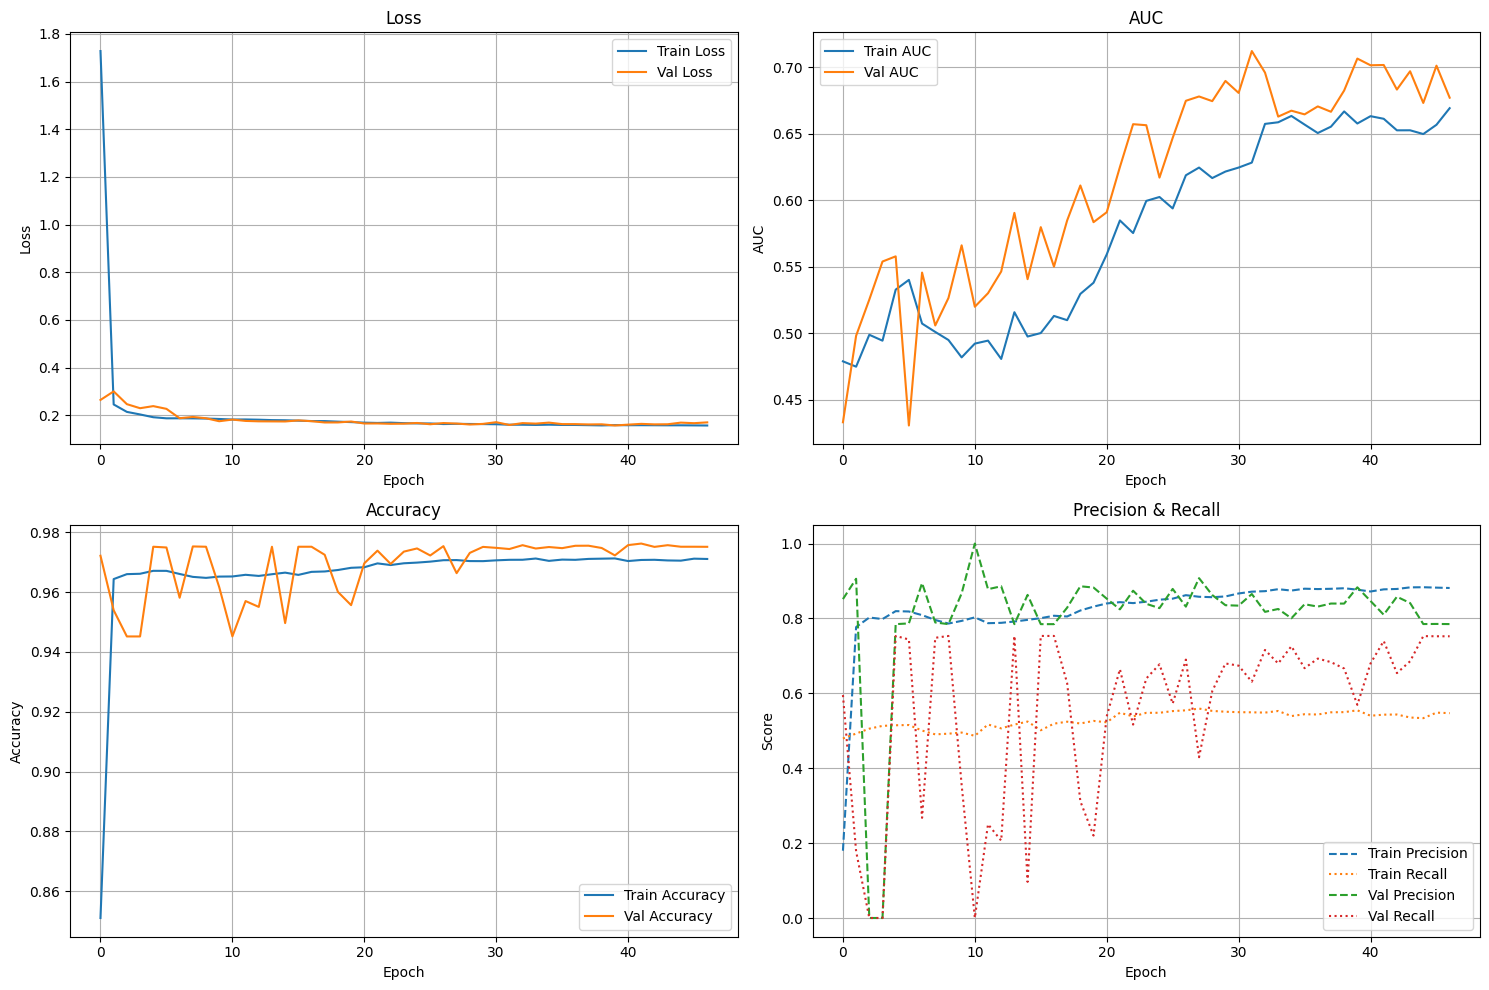

✓ Training curves saved to ../.data/artifacts/multilabel_v3_full_length//training_history.png


In [19]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Loss', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC')
axes[0, 1].set_title('AUC', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[1, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1, 0].set_title('Accuracy', fontsize=12)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', linestyle='--')
axes[1, 1].plot(history.history['recall'], label='Train Recall', linestyle=':')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linestyle='--')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linestyle=':')
axes[1, 1].set_title('Precision & Recall', fontsize=12)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()

print(f"✓ Training curves saved to {OUTPUT_DIR}/training_history.png")

## 8. Evaluation with Disease Names

In [20]:
# Get predictions on test set
print("Generating predictions on test set...")

y_true_test = y_data[test_idx]
y_pred_proba_test = model.predict(test_dataset, verbose=1)
y_pred_test = (y_pred_proba_test > 0.5).astype(int)

print("✓ Predictions complete")

Generating predictions on test set...
134/134 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step
✓ Predictions complete


In [21]:
# Overall metrics
print("="*80)
print("OVERALL TEST METRICS")
print("="*80)

# Subset accuracy (exact match)
subset_acc = np.mean(np.all(y_true_test == y_pred_test, axis=1))
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")

# Hamming loss
hamming = hamming_loss(y_true_test, y_pred_test)
print(f"Hamming Loss: {hamming:.4f}")

# F1 scores
f1_micro = f1_score(y_true_test, y_pred_test, average='micro', zero_division=0)
f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)
f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)

print(f"F1-Score (Micro):    {f1_micro:.4f}")
print(f"F1-Score (Macro):    {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Precision & Recall
prec_micro = precision_score(y_true_test, y_pred_test, average='micro', zero_division=0)
rec_micro = recall_score(y_true_test, y_pred_test, average='micro', zero_division=0)

print(f"Precision (Micro):   {prec_micro:.4f}")
print(f"Recall (Micro):      {rec_micro:.4f}")

OVERALL TEST METRICS
Subset Accuracy (Exact Match): 0.6712
Hamming Loss: 0.0252
F1-Score (Micro):    0.7368
F1-Score (Macro):    0.0451
F1-Score (Weighted): 0.6481
Precision (Micro):   0.8676
Recall (Micro):      0.6402


In [22]:
# Per-class metrics with DISEASE NAMES ONLY (no ICD codes)
print("\n" + "="*80)
print("PER-CLASS METRICS (Grouped by Disease Category)")
print("="*80)

per_class_results = {}

# Group by disease category
for group_name, group_icds in DISEASE_GROUPS.items():
    print(f"\n{group_name.upper()}:")
    print("-" * 80)
    
    for icd in group_icds:
        if icd not in ICD_CODES:
            continue
        
        idx = ICD_CODES.index(icd)
        disease_name = DISEASE_NAMES[idx]  # Get disease name
        
        y_true_class = y_true_test[:, idx]
        y_pred_class = y_pred_test[:, idx]
        y_pred_proba_class = y_pred_proba_test[:, idx]
        
        support = int(y_true_class.sum())
        
        if support > 0:
            precision = precision_score(y_true_class, y_pred_class, zero_division=0)
            recall = recall_score(y_true_class, y_pred_class, zero_division=0)
            f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
            
            try:
                roc_auc = roc_auc_score(y_true_class, y_pred_proba_class)
            except:
                roc_auc = 0.0
            
            per_class_results[disease_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc,
                'support': support
            }
            
            # Print ONLY disease name (no ICD code)
            print(f"\n{disease_name}:")  # Changed from showing ICD code
            print(f"  Support:   {support:4d}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"  ROC-AUC:   {roc_auc:.4f}")

# Healthy class
print(f"\nHEALTHY:")
print("-" * 80)

idx = ICD_CODES.index('Healthy')
disease_name = DISEASE_NAMES[idx]  # "Healthy"

y_true_class = y_true_test[:, idx]
y_pred_class = y_pred_test[:, idx]
y_pred_proba_class = y_pred_proba_test[:, idx]

support = int(y_true_class.sum())

if support > 0:
    precision = precision_score(y_true_class, y_pred_class, zero_division=0)
    recall = recall_score(y_true_class, y_pred_class, zero_division=0)
    f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_true_class, y_pred_proba_class)
    except:
        roc_auc = 0.0
    
    per_class_results[disease_name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'support': support
    }
    
    print(f"\n{disease_name}:")  # Just "Healthy"
    print(f"  Support:   {support:4d}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")


PER-CLASS METRICS (Grouped by Disease Category)

MYOCARDITIS:
--------------------------------------------------------------------------------

Acute Myocarditis:
  Support:     10
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5212

Myocarditis Unspecified:
  Support:     28
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.4855

CARDIOMYOPATHY:
--------------------------------------------------------------------------------

Dilated Cardiomyopathy:
  Support:     17
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.6764

Hypertrophic Cardiomyopathy:
  Support:      2
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.8030

Cardiomyopathy Unspecified:
  Support:      6
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7474

KAWASAKI:
--------------------------------------------------------------------------------

Kawasaki Disease:
  Support:     22
  Precisi

## 9. Prediction Visualization

In [23]:
def show_prediction_with_names(sample_idx, threshold=0.5):
    """
    Display prediction with DISEASE NAMES ONLY (no ICD codes).
    """
    print(f"\n{'='*80}")
    print(f"Sample {sample_idx + 1}")
    print(f"{'='*80}")
    
    # Get data
    test_sample_idx = test_idx[sample_idx]
    y_true = y_true_test[sample_idx]
    y_pred_proba = y_pred_proba_test[sample_idx]
    
    # True labels - DISEASE NAMES ONLY
    true_indices = np.where(y_true == 1)[0]
    print(f"\nTrue Diagnoses ({len(true_indices)}):")
    if len(true_indices) > 0:
        for idx in true_indices:
            print(f"  - {DISEASE_NAMES[idx]}")  # ONLY disease name
    else:
        print("  - None")
    
    # Predicted labels - DISEASE NAMES ONLY
    pred_indices = np.where(y_pred_proba > threshold)[0]
    print(f"\nPredicted Diagnoses (threshold={threshold}):")
    if len(pred_indices) > 0:
        for idx in sorted(pred_indices, key=lambda i: -y_pred_proba[i]):
            prob = y_pred_proba[idx]
            marker = "✓" if y_true[idx] == 1 else " "
            print(f"  {marker} {DISEASE_NAMES[idx]}: {prob:.4f}")  # ONLY disease name
    else:
        print("  - None")
    
    # Top 5 predictions - DISEASE NAMES ONLY
    print(f"\nTop 5 Predictions (all probabilities):")
    top_5 = np.argsort(y_pred_proba)[-5:][::-1]
    for idx in top_5:
        prob = y_pred_proba[idx]
        marker = "✓" if y_true[idx] == 1 else " "
        print(f"  {marker} {DISEASE_NAMES[idx]}: {prob:.4f}")  # ONLY disease name


# Show predictions for random samples
print("\nSample Predictions:")
random_samples = np.random.choice(len(test_idx), size=min(5, len(test_idx)), replace=False)
for i in random_samples:
    show_prediction_with_names(i)


Sample Predictions:

Sample 1004

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  ✓ Healthy: 0.6224

Top 5 Predictions (all probabilities):
  ✓ Healthy: 0.6224
    Ventricular Septal Defect: 0.1440
    Atrial Septal Defect: 0.1220
    Patent Ductus Arteriosus: 0.0966
    Myocarditis Unspecified: 0.0830

Sample 1512

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  ✓ Healthy: 0.5838

Top 5 Predictions (all probabilities):
  ✓ Healthy: 0.5838
    Ventricular Septal Defect: 0.1731
    Atrial Septal Defect: 0.1489
    Patent Ductus Arteriosus: 0.1004
    Myocarditis Unspecified: 0.0938

Sample 973

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  ✓ Healthy: 0.5073

Top 5 Predictions (all probabilities):
  ✓ Healthy: 0.5073
    Ventricular Septal Defect: 0.2286
    Atrial Septal Defect: 0.2049
    Congenital Heart Malformation: 0.1354
    Patent Ductus Arteriosus: 0.1284

Sample 894

True Diagnoses (1):
  - Healthy

Pred


ECG Signal Visualizations:


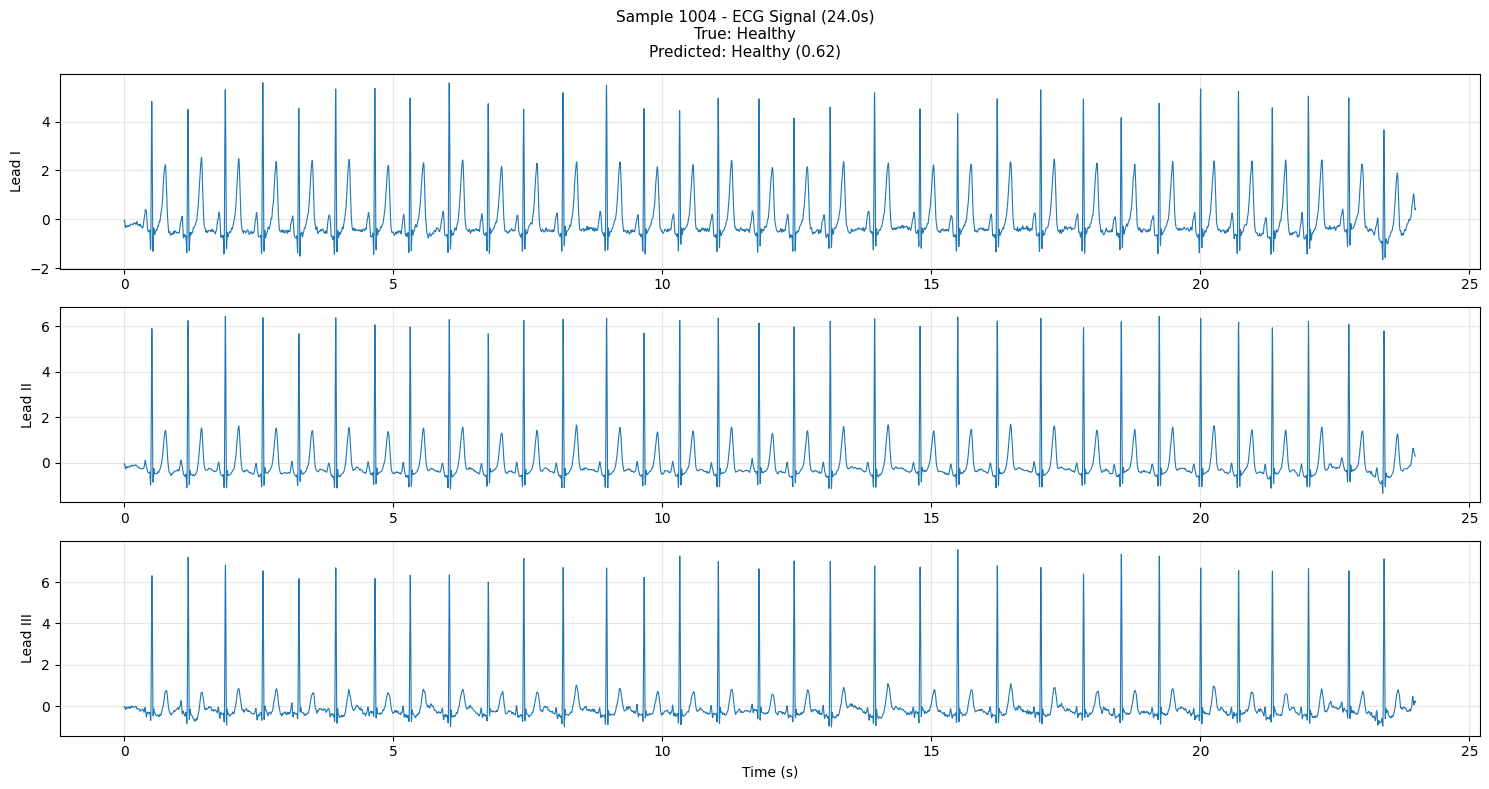

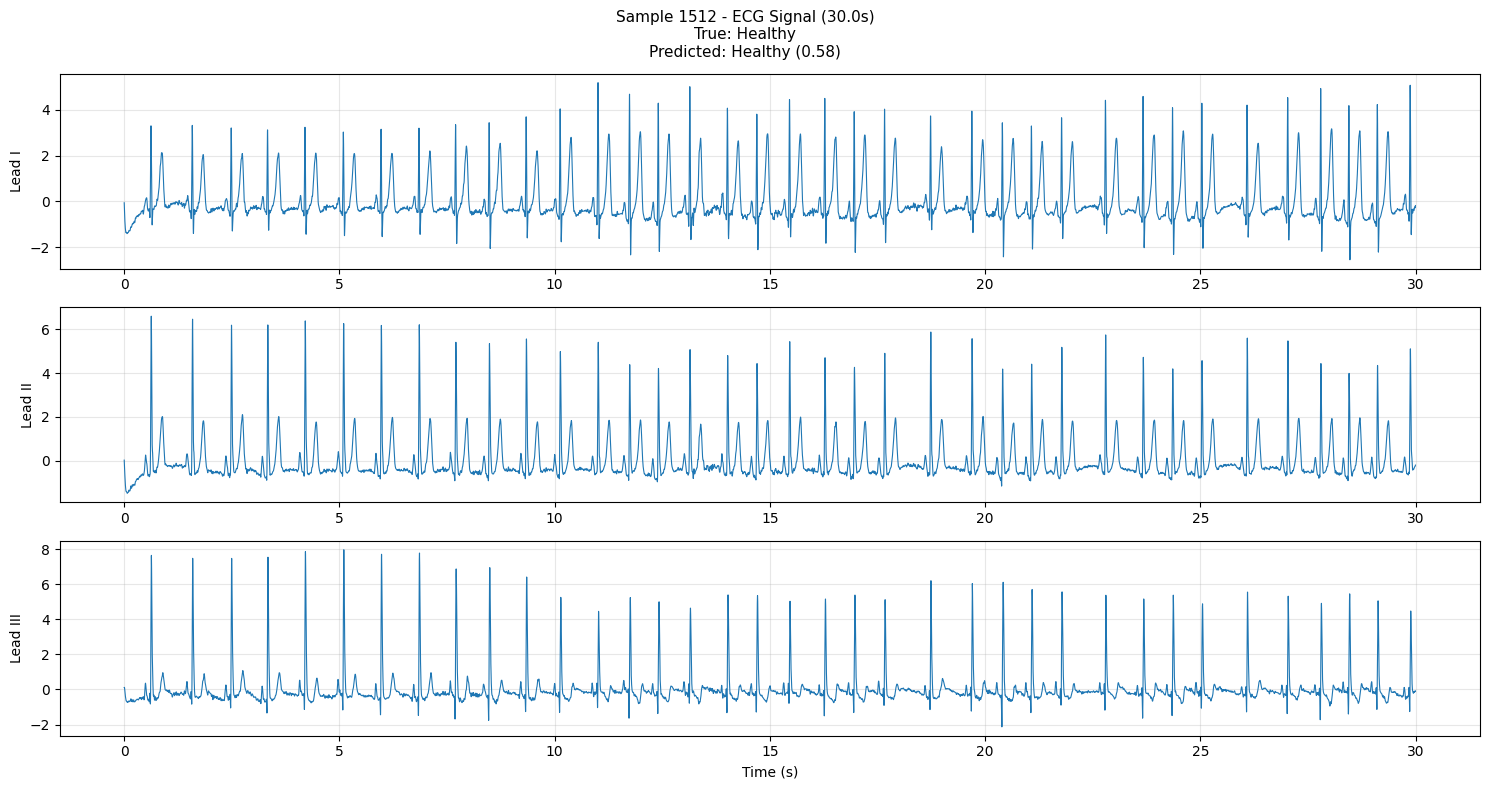

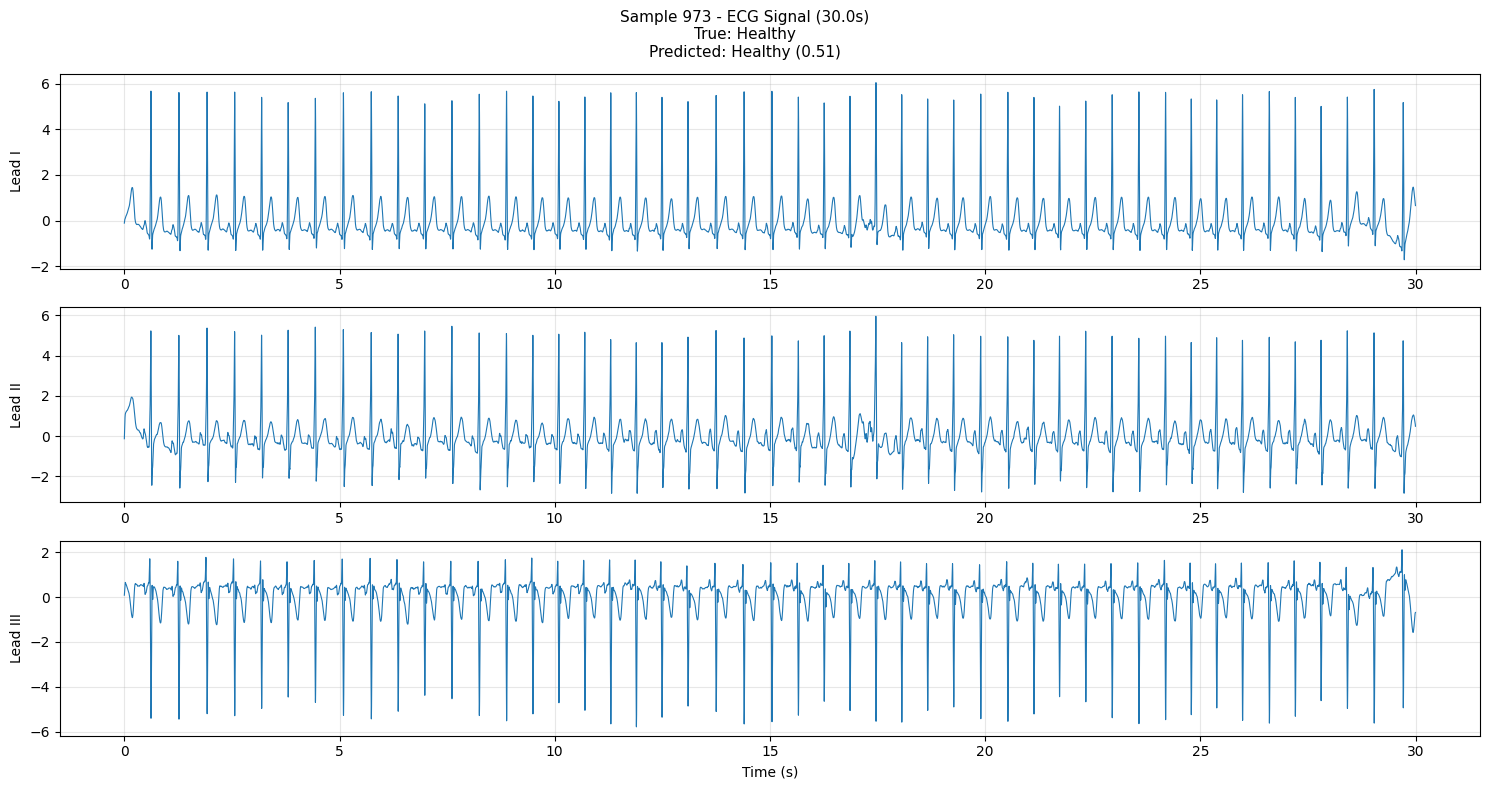

In [24]:
# Plot ECG signal with predictions
def plot_ecg_with_predictions(sample_idx, num_leads=3):
    """
    Plot ECG signal with true and predicted labels (DISEASE NAMES ONLY).
    """
    test_sample_idx = test_idx[sample_idx]
    ecg_signal = X_data[test_sample_idx]
    y_true = y_true_test[sample_idx]
    y_pred_proba = y_pred_proba_test[sample_idx]
    
    # Get disease names
    true_labels = [DISEASE_NAMES[j] for j in range(NUM_CLASSES) if y_true[j] == 1]
    pred_labels = [(DISEASE_NAMES[j], y_pred_proba[j]) 
                  for j in range(NUM_CLASSES) if y_pred_proba[j] > 0.5]
    
    # Plot
    fig, axes = plt.subplots(num_leads, 1, figsize=(15, 8))
    if num_leads == 1:
        axes = [axes]
    
    time = np.arange(len(ecg_signal)) / TARGET_FS
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    for i in range(num_leads):
        axes[i].plot(time, ecg_signal[:, i], linewidth=0.8)
        axes[i].set_ylabel(f'Lead {lead_names[i]}', fontsize=10)
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)', fontsize=10)
    
    # Title with disease names
    title = f'Sample {sample_idx + 1} - ECG Signal ({len(ecg_signal)/TARGET_FS:.1f}s)\n'
    title += f'True: {", ".join(true_labels) if true_labels else "None"}\n'
    if pred_labels:
        pred_str = ", ".join([f"{l} ({p:.2f})" for l, p in pred_labels])
        title += f'Predicted: {pred_str}'
    else:
        title += 'Predicted: None'
    
    plt.suptitle(title, fontsize=11, y=0.98)
    plt.tight_layout()
    plt.show()


# Plot a few examples
print("\nECG Signal Visualizations:")
for i in random_samples[:3]:
    plot_ecg_with_predictions(i, num_leads=3)

## 10. Save Model & Metadata

In [25]:
# Save final model
final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.keras')
model.save(final_model_path)
print(f"✓ Model saved to {final_model_path}")

# Save comprehensive metadata with DISEASE NAMES
results_metadata = {
    'model_name': MODEL_NAME,
    'version': NOTEBOOK_VERSION,
    'created': datetime.now().isoformat(),
    
    # Classes - DISEASE NAMES ONLY in main list
    'num_classes': NUM_CLASSES,
    'disease_names': DISEASE_NAMES,  # Main output list - names only
    'icd_codes': ICD_CODES,  # Reference only
    'icd_to_disease_name': ICD_TO_DISEASE_NAME,  # Mapping reference
    'disease_groups': DISEASE_GROUPS,
    
    # Architecture
    'architecture': {
        'type': 'Enhanced 1D CNN',
        'blocks': '64→128→256→512 filters',
        'features': ['Squeeze-Excitation', 'Temporal Attention', 'Residual Connections'],
        'pooling': 'Adaptive (Global Avg + Max)',
        'total_params': int(model.count_params())
    },
    
    # Training
    'training': {
        'epochs': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'loss': 'Focal Loss (alpha=0.25, gamma=2.0)',
        'optimizer': 'Adam'
    },
    
    # Data
    'data': {
        'total_samples': len(X_data),
        'train_samples': len(train_idx),
        'val_samples': len(val_idx),
        'test_samples': len(test_idx),
        'sampling_rate': TARGET_FS,
        'num_channels': TARGET_CHANNELS,
        'variable_length': True,
        'length_range': f"{lengths_data.min()/TARGET_FS:.1f}s - {lengths_data.max()/TARGET_FS:.1f}s"
    },
    
    # Test metrics
    'test_metrics': {
        'subset_accuracy': float(subset_acc),
        'hamming_loss': float(hamming),
        'f1_micro': float(f1_micro),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'precision_micro': float(prec_micro),
        'recall_micro': float(rec_micro)
    },
    
    # Per-class results (DISEASE NAMES ONLY)
    'per_class_results': per_class_results
}

# Save metadata
metadata_path = os.path.join(OUTPUT_DIR, 'model_results.json')
with open(metadata_path, 'w') as f:
    json.dump(results_metadata, f, indent=2)

print(f"✓ Metadata saved to {metadata_path}")

# Upload to HuggingFace (if enabled)
if ENABLE_HF_UPLOAD and MODEL_REPO and api:
    print(f"\nUploading final model to HuggingFace...")

    try:
        # Upload model
        api.upload_file(
            path_or_fileobj=final_model_path,
            path_in_repo="final_model.keras",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Final trained model"
        )
        print("✓ Final model uploaded")

        # Upload metadata
        api.upload_file(
            path_or_fileobj=metadata_path,
            path_in_repo="model_results.json",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Add model metadata"
        )
        print("✓ Metadata uploaded")

        # Upload training history
        history_csv = os.path.join(OUTPUT_DIR, 'training_history.csv')
        if os.path.exists(history_csv):
            api.upload_file(
                path_or_fileobj=history_csv,
                path_in_repo="training_history.csv",
                repo_id=MODEL_REPO,
                repo_type="model",
                commit_message="Add training history"
            )
            print("✓ Training history uploaded")

        # Upload training plot
        history_plot = os.path.join(OUTPUT_DIR, 'training_history.png')
        if os.path.exists(history_plot):
            api.upload_file(
                path_or_fileobj=history_plot,
                path_in_repo="training_history.png",
                repo_id=MODEL_REPO,
                repo_type="model",
                commit_message="Add training visualization"
            )
            print("✓ Training visualization uploaded")

        print(f"\n{'='*60}")
        print(f"✓ All artifacts uploaded to HuggingFace!")
        print(f"View at: https://huggingface.co/{MODEL_REPO}")
        print(f"{'='*60}")

    except Exception as e:
        print(f"Warning: Could not upload to HF: {e}")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Model: {final_model_path}")
print(f"Metadata: {metadata_path}")
print(f"Training history: {os.path.join(OUTPUT_DIR, 'training_history.csv')}")
print(f"\nTest F1-Score (Macro): {f1_macro:.4f}")

✓ Model saved to ../.data/artifacts/multilabel_v3_full_length/Enhanced_1D_CNN_19Classes_v3_final.keras
✓ Metadata saved to ../.data/artifacts/multilabel_v3_full_length/model_results.json

Uploading final model to HuggingFace...


Processing Files (1 / 1): 100%|██████████| 49.5MB / 49.5MB, 10.8MB/s  
New Data Upload: 100%|██████████| 49.5MB / 49.5MB, 10.8MB/s  


✓ Final model uploaded
✓ Metadata uploaded
✓ Training history uploaded


Processing Files (1 / 1): 100%|██████████|  271kB /  271kB,  667kB/s  
New Data Upload: 100%|██████████|  271kB /  271kB,  667kB/s  


✓ Training visualization uploaded

✓ All artifacts uploaded to HuggingFace!
View at: https://huggingface.co/Neural-Network-Project/ECG-Disease-Classifier

TRAINING COMPLETE!
Model: ../.data/artifacts/multilabel_v3_full_length/Enhanced_1D_CNN_19Classes_v3_final.keras
Metadata: ../.data/artifacts/multilabel_v3_full_length/model_results.json
Training history: ../.data/artifacts/multilabel_v3_full_length/training_history.csv

Test F1-Score (Macro): 0.0451


## 11. Generate Model Card (HuggingFace)

In [26]:
# Generate model card for HuggingFace (if enabled)
if ENABLE_HF_UPLOAD and MODEL_REPO:
    disease_names_str = '\n'.join([f"{i+1}. {name}" for i, name in enumerate(DISEASE_NAMES)])

    model_card = f"""---
language: en
tags:
- ecg
- cardiology
- medical
- pediatric
- time-series
- multi-label-classification
- tensorflow
- cnn
datasets:
- Neural-Network-Project/ECG-database
metrics:
- f1
- auc
- precision
- recall
library_name: tensorflow
---

# ECG Disease Classifier - 19 Cardiac Conditions

Multi-label classification model for detecting 19 cardiac conditions from pediatric ECG signals.

## Model Description

Enhanced 1D CNN with Squeeze-Excitation blocks and temporal attention for variable-length ECG classification.

**Architecture:** 64→128→256→512 filters with residual connections
**Training:** Focal loss for class imbalance
**Input:** Variable-length 12-lead ECG (5-120 seconds at 500 Hz)

## Disease Classes

{disease_names_str}

## Performance

- F1-Score (Macro): {f1_macro:.4f}
- F1-Score (Micro): {f1_micro:.4f}
- Subset Accuracy: {subset_acc:.4f}

## Intended Use

⚠️ **Research and educational purposes only** - NOT for clinical diagnosis

## Training Details

- Batch Size: {BATCH_SIZE}
- Epochs: {len(history.history['loss'])}
- Loss: Focal Loss (α=0.25, γ=2.0)
- Optimizer: Adam (lr={LEARNING_RATE})

## Citation

```bibtex
@misc{{ecg-classifier-2025,
  author = {{Neural-Network-Project}},
  title = {{ECG Disease Classifier}},
  year = {{2025}},
  publisher = {{Hugging Face}},
  url = {{https://huggingface.co/{MODEL_REPO}}}
}}
```
"""

    # Save locally
    readme_path = os.path.join(OUTPUT_DIR, 'README.md')
    with open(readme_path, 'w') as f:
        f.write(model_card)

    print("✓ Model card created")

    # Upload to HuggingFace
    try:
        api.upload_file(
            path_or_fileobj=readme_path,
            path_in_repo="README.md",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Add model card"
        )
        print("✓ Model card uploaded to HuggingFace")
    except Exception as e:
        print(f"Warning: Could not upload model card: {e}")
else:
    print("Skipping model card generation (ENABLE_HF_UPLOAD=False)")

UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 575: character maps to <undefined>

## Summary

This notebook implements an enhanced 1D CNN for 19-class multi-label ECG classification:

**Key Features:**
- ✅ Processes full-length variable recordings (5-120 seconds, no windowing)
- ✅ 19 classes (18 cardiac diseases + Healthy)
- ✅ Enhanced architecture with SE blocks and temporal attention
- ✅ Focal loss for class imbalance
- ✅ **All outputs show disease names only** (not ICD codes)

**Architecture:**
- 64→128→256→512 filters with residual connections
- Squeeze-Excitation blocks for channel attention
- Temporal attention for time-series focus
- Adaptive pooling for variable lengths

**Next Steps:**
- Fine-tune threshold per class
- Analyze attention weights
- Deploy for inference